# Mexican population in major cities? 

### Import python/pandas tools

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 1000
pd.set_option("display.max_colwidth", None)

### Get data with [census-data-downloader](https://github.com/datadesk/census-data-downloader)

In [4]:
# !censusdatadownloader latino places

In [5]:
# !pip install census-data-downloader

In [6]:
# !censusdatadownloader latino states

### Read data and define types

In [7]:
src = pd.read_csv(
    "processed/acs5_2019_latino_places.csv",
    low_memory=False,
    dtype={
        "universe": int,
        "mexican": int,
        "mexican_moe": int,
        "hispanic_or_latino": int,
        "geoid": str,
    },
)

### Limit the dataframe to (renamed) columns we need

In [8]:
df = (
    src[src["universe"] > 500000][
        ["geoid", "name", "universe", "hispanic_or_latino", "mexican"]
    ]
    .reset_index(drop=True)
    .copy()
    .rename(
        columns={
            "universe": "all_pop",
            "mexican": "mexican_pop",
            "hispanic_or_latino": "hisp_pop",
        }
    )
)

### Get population shares

In [9]:
df["hisp_pct_pop"] = ((df["hisp_pop"] / df["all_pop"]) * 100).round(2)
df["mex_pct_all_pop"] = ((df["mexican_pop"] / df["all_pop"]) * 100).round(2)
df["mex_pct_hisp_pop"] = ((df["mexican_pop"] / df["hisp_pop"]) * 100).round(2)

### Clean up place names

In [10]:
df["name"] = (
    df["name"]
    .str.replace(" municipality", "", regex=False)
    .str.replace(" city", "", regex=False)
    .str.replace(" zona urbana", "", regex=False)
    .str.replace(" (balance)", "", regex=False)
    .str.replace(" County metro government", "", regex=False)
    .str.replace(" metropolitan government", "", regex=False)
)

### Just one place

In [11]:
df[df["geoid"] == "0644000"]

,geoid,name,all_pop,hisp_pop,mexican_pop,hisp_pct_pop,mex_pct_all_pop,mex_pct_hisp_pop
3,0644000,"Los Angeles, California",3966936,1922409,1277998,48.46,32.22,66.48


### Places with highest share of population as Mexican

In [12]:
df.sort_values("mex_pct_all_pop", ascending=False).head()

,geoid,name,all_pop,hisp_pop,mexican_pop,hisp_pct_pop,mex_pct_all_pop,mex_pct_hisp_pop
29,4824000,"El Paso, Texas",679813,553076,522794,81.36,76.90,94.52
32,4865000,"San Antonio, Texas",1508083,968712,858642,64.23,56.94,88.64
2,0627000,"Fresno, California",525010,260447,240817,49.61,45.87,92.46
1,0477000,"Tucson, Arizona",541482,236118,213978,43.61,39.52,90.62
0,0455000,"Phoenix, Arizona",1633017,695981,624916,42.62,38.27,89.79


### Export dataframe

In [13]:
df.to_csv("output/mexican_pop_place.csv", index=False)

---

### Read geography file for places

In [14]:
gdf_poly = gpd.read_file(
    "../../../data/gis/census/places/nhgis0001_shape/nhgis0001_shapefile_tl2019_us_place_2019/US_place_2019.shp"
)

### Convert polygons to points

In [15]:
gdf_points = gdf_poly.copy()

In [16]:
gdf_points["geometry"] = gdf_points["geometry"].centroid

### Clean up column names

In [17]:
gdf_points.columns = gdf_points.columns.str.lower()

In [18]:
geodf = gdf_points[["geoid", "geometry"]].copy()

---

### Merge 'em

In [19]:
merged_geo = pd.merge(geodf, df, right_on="geoid")

In [20]:
merged_geo.head()

,geoid,geometry,name,all_pop,hisp_pop,mexican_pop,hisp_pct_pop,mex_pct_all_pop,mex_pct_hisp_pop
0,0455000,POINT (-1476289.965 -314363.699),"Phoenix, Arizona",1633017,695981,624916,42.62,38.27,89.79
1,0477000,POINT (-1390789.857 -488703.643),"Tucson, Arizona",541482,236118,213978,43.61,39.52,90.62
2,0627000,POINT (-2081874.463 181656.710),"Fresno, California",525010,260447,240817,49.61,45.87,92.46
3,0644000,POINT (-2032633.900 -137838.626),"Los Angeles, California",3966936,1922409,1277998,48.46,32.22,66.48
4,0664000,POINT (-2172026.924 412350.330),"Sacramento, California",500930,144582,123228,28.86,24.60,85.23


<AxesSubplot:>

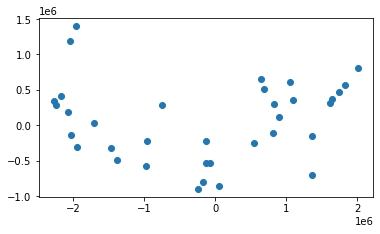

In [21]:
merged_geo.plot()

In [22]:
merged_geo = merged_geo.to_crs("epsg:4326")

In [23]:
merged_geo["lon"] = merged_geo.geometry.apply(lambda p: p.x)
merged_geo["lat"] = merged_geo.geometry.apply(lambda p: p.y)

In [24]:
merged_geo.to_file("output/large_places_hispanic_pop.geojson", driver="GeoJSON")

In [25]:
merged_geo[
    [
        "geoid",
        "name",
        "all_pop",
        "hisp_pop",
        "mexican_pop",
        "hisp_pct_pop",
        "mex_pct_all_pop",
        "mex_pct_hisp_pop",
        "lon",
        "lat",
    ]
].to_csv("output/mexican_pop_place_datawrapper.csv", index=False)